In [1]:
import glob
import os
import sys

import time
import numpy as np
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch
from torch_cluster import knn_graph

from itertools import cycle
from sklearn.metrics import roc_curve, auc
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

from tqdm.notebook import tqdm

from torch_geometric.explain import Explainer, GNNExplainer

import xai4hep

# Get dataset

In [2]:
# load the datafiles
def load_data(dataset_path, flag, n_files=-1):
    data_files = glob.glob(f"{dataset_path}/{flag}/processed/*")
        
    data = []
    for i, file in enumerate(data_files):
        data += torch.load(f"{dataset_path}/{flag}/processed/data_{i}.pt")
        print(f"--- loaded file {i} from `{flag}` directory")
        if n_files!=-1 and i==n_files-1:
            break
                
    return data

dataset_path = "../data/toptagging/"

dataset = load_data(dataset_path, "test", n_files=1)  # use test directory because it contains subjet info

--- loaded file 0 from `test` directory


In [3]:
dataset

[Data(x=[17, 7], y=0, px=[17], py=[17], pz=[17], E=[17]),
 Data(x=[61, 7], y=0, px=[61], py=[61], pz=[61], E=[61]),
 Data(x=[45, 7], y=0, px=[45], py=[45], pz=[45], E=[45]),
 Data(x=[74, 7], y=0, px=[74], py=[74], pz=[74], E=[74]),
 Data(x=[30, 7], y=0, px=[30], py=[30], pz=[30], E=[30]),
 Data(x=[37, 7], y=0, px=[37], py=[37], pz=[37], E=[37]),
 Data(x=[79, 7], y=0, px=[79], py=[79], pz=[79], E=[79]),
 Data(x=[41, 7], y=0, px=[41], py=[41], pz=[41], E=[41]),
 Data(x=[92, 7], y=0, px=[92], py=[92], pz=[92], E=[92]),
 Data(x=[17, 7], y=0, px=[17], py=[17], pz=[17], E=[17]),
 Data(x=[34, 7], y=0, px=[34], py=[34], pz=[34], E=[34]),
 Data(x=[58, 7], y=0, px=[58], py=[58], pz=[58], E=[58]),
 Data(x=[64, 7], y=0, px=[64], py=[64], pz=[64], E=[64]),
 Data(x=[47, 7], y=0, px=[47], py=[47], pz=[47], E=[47]),
 Data(x=[33, 7], y=0, px=[33], py=[33], pz=[33], E=[33]),
 Data(x=[25, 7], y=0, px=[25], py=[25], pz=[25], E=[25]),
 Data(x=[60, 7], y=0, px=[60], py=[60], pz=[60], E=[60]),
 Data(x=[51, 7

In [4]:
dataset[0].x

tensor([[ 1.9442e-02,  9.3275e-02,  5.3207e+00,  5.3862e+00, -1.0834e+00,
         -1.0833e+00,  9.5280e-02],
        [-5.8873e-03, -3.4971e-02,  4.9779e+00,  5.0347e+00, -1.4262e+00,
         -1.4347e+00,  3.5463e-02],
        [-2.7067e-02, -2.2574e-02,  4.2899e+00,  4.3400e+00, -2.1142e+00,
         -2.1295e+00,  3.5245e-02],
        [-3.8218e-02, -2.3472e-02,  4.1150e+00,  4.1617e+00, -2.2891e+00,
         -2.3078e+00,  4.4851e-02],
        [ 5.3362e-03, -3.5016e-02,  3.9994e+00,  4.0600e+00, -2.4047e+00,
         -2.4095e+00,  3.5420e-02],
        [-1.7531e-02, -2.8692e-02,  3.5385e+00,  3.5916e+00, -2.8656e+00,
         -2.8778e+00,  3.3624e-02],
        [-2.0561e-01, -6.5708e-01,  2.3877e+00,  2.3976e+00, -4.0164e+00,
         -4.0719e+00,  6.8849e-01],
        [ 8.0407e-02, -2.2516e-02,  1.5615e+00,  1.6500e+00, -4.8426e+00,
         -4.8195e+00,  8.3500e-02],
        [ 9.8348e-02, -6.3129e-02,  1.5044e+00,  1.6002e+00, -4.8997e+00,
         -4.8693e+00,  1.1687e-01],
        [-

In [5]:
loader = DataLoader(dataset, batch_size=40)

# Get model

In [10]:
# the actual particlenet model can be imported via `xai4hep.particlenet import ParticleNet`
# the model is below is a simplified one

from typing import Callable, Union

import torch.nn.functional as F
from torch import Tensor
from torch_cluster import knn_graph
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import MessagePassing, EdgeConv
from torch_geometric.typing import Adj, PairTensor


class EdgeConvBlock(nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()

        layers = []

        layers.append(nn.Linear(in_size * 2, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(depth):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.edge_conv = EdgeConv(nn.Sequential(*layers), aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)


class ParticleNet(nn.Module):
    def __init__(
        self,
        node_feat_size,
        num_classes=1,
        depth=1,
    ):
        super(ParticleNet, self).__init__()

        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.fc_size = 256

        # define the edgeconvblocks
        self.edge_conv_block = EdgeConvBlock(node_feat_size, 256, depth=depth)

        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(node_feat_size + 256, self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x, edge_index, batch=None):

        # input transformations
        x[:, 2] = (x[:, 2] - 1.7) * 0.7  # part_pt_log
        x[:, 3] = (x[:, 3] - 2.0) * 0.7  # part_e_log
        x[:, 4] = (x[:, 4] + 4.7) * 0.7  # part_logptrel
        x[:, 5] = (x[:, 5] + 4.7) * 0.7  # part_logerel
        x[:, 6] = (x[:, 6] - 0.2) * 4.7  # part_deltaR

        # useful placeholders for LRP studies
        out = self.edge_conv_block(x, edge_index)
        x = torch.cat((out, x), dim=1)  # concatenating with latent features i.e. skip connections per EdgeConvBlock

        if batch is None:
            x = x.sum(axis=0)
        else:
            x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sig(x)

        return x
    
# setup the input/output dimension of the model
k = 12

model_kwargs = {
    "node_feat_size": 7,
    "num_classes": 1,
    "depth": 3,
}

model = ParticleNet(**model_kwargs)
model.train()    

ParticleNet(
  (edge_conv_block): EdgeConvBlock(
    (edge_conv): EdgeConv(nn=Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    ))
  )
  (fc1): Linear(in_features=263, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [7]:
# train the model
def train(loader, model, idx=100):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for i, batch in enumerate(loader):

        edge_index = knn_graph(batch.x[:, :2], k, batch.batch)

        preds = model(batch.x, edge_index, batch.batch)

        # compute the invariance loss which is contrained by the other loss terms
        loss = criterion(preds, batch.y.unsqueeze(-1).float())

        # backprop
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()

        optimizer.step()
        print(f"loss: {loss.detach()}")

        if i == idx:
            break

train(loader, model, idx=100)

loss: 0.6831254363059998
loss: 0.7084121108055115
loss: 0.9011742472648621
loss: 0.4889243245124817
loss: 0.8769220113754272
loss: 0.511050820350647
loss: 0.5040419697761536
loss: 0.6639550924301147
loss: 0.48320096731185913
loss: 0.5725436806678772
loss: 0.4217025637626648
loss: 0.4421778619289398
loss: 0.3499985337257385
loss: 0.4242607057094574
loss: 0.356584370136261
loss: 0.28981295228004456
loss: 0.3605875074863434
loss: 0.2561497092247009
loss: 0.24217729270458221
loss: 0.43258920311927795
loss: 0.6058160662651062
loss: 0.4339587688446045
loss: 0.3094384968280792
loss: 0.7658141255378723
loss: 0.4507075250148773
loss: 0.26024749875068665
loss: 0.4767727255821228
loss: 0.5817710161209106
loss: 1.0253596305847168
loss: 0.3141597509384155
loss: 0.3641303479671478
loss: 0.3389536440372467
loss: 0.6577080488204956
loss: 0.42164555191993713
loss: 0.261353462934494
loss: 0.8689254522323608
loss: 0.7916925549507141
loss: 0.3345469534397125
loss: 0.32885751128196716
loss: 0.6850041151046

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

271105

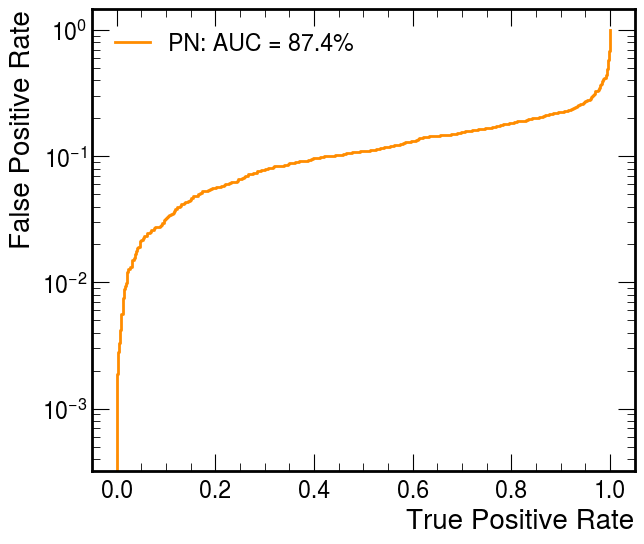

In [9]:
# test
targets_ = []
preds_ = []
for i, batch in enumerate(loader):
    edge_index = knn_graph(batch.x[:, :2], k)

    preds_ += model(batch.x, edge_index, batch.batch).tolist()
    targets_ += batch.y.tolist()
    
    if i==100:
        break

fig, ax = plt.subplots(figsize=[7,6])

fpr, tpr, _ = roc_curve(targets_, preds_)
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"PN: AUC = {round(auc(fpr, tpr)*100,2)}%",
)

# plt.xlim([0.0, 1.0])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale("log")
plt.legend()

# GNNExplainer

In [11]:
xai_loader = DataLoader(dataset, batch_size=1)

In [12]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=0, lr=0.003),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
#     threshold_config=dict(threshold_type='topk', value=15),
)

out = {}
out["trained"] = {}
out["trained"]["Top"], out["trained"]["QCD"] = [], []

for i, batch in enumerate(xai_loader):
    print(f"# {i}")
    
    batch.edge_index = knn_graph(batch.x[:, :2], k)

    explanation = explainer(batch.x, batch.edge_index, target=batch.y)
    if batch.y==1:
        out["trained"]["Top"] += explanation.edge_mask.tolist()        
    else:
        out["trained"]["QCD"] += explanation.edge_mask.tolist() 
        
    if i==100:
        break

# 0
# 1
# 2
# 3
# 4
# 5
# 6
# 7
# 8
# 9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19


/Users/fmokhtar/miniforge3/envs/test/lib/python3.9/site-packages/torch_geometric/explain/explainer.py:189: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99
# 100


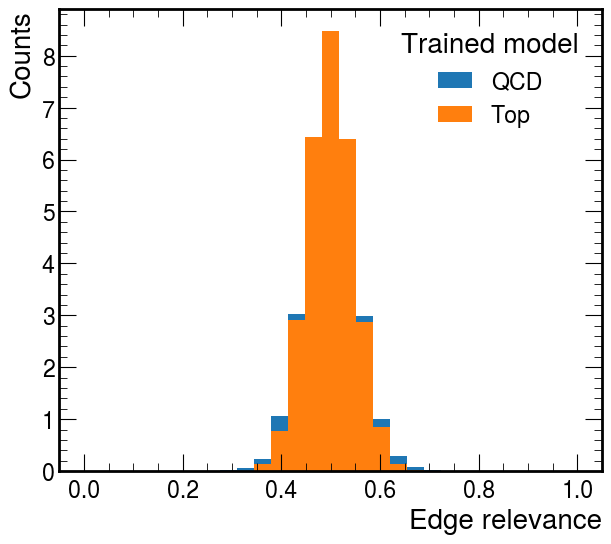

In [15]:
fig, ax = plt.subplots(figsize=[7,6])

ax.hist(out["trained"]["QCD"], bins=np.linspace(0,1,30), label=f"QCD", density=True)
ax.hist(out["trained"]["Top"], bins=np.linspace(0,1,30), label=f"Top", density=True)

# plt.xlim([0.0, 1.0])
plt.ylabel("Counts")
plt.xlabel("Edge relevance")
# plt.yscale("log")
plt.legend(title="Trained model")